In [13]:
#import fix_yahoo_finance as yf
#from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
from matplotlib import dates, ticker
import math
from datetime import timedelta
from matplotlib.widgets import Button


In [14]:

def txt2listMarketHour(fname=''):
    start_time = '143000'
    end_time = '210000'
    started = False
    # https://stackoverflow.com/questions/23286254/convert-list-to-a-list-of-tuples-python
    myData = []
    with open(fname, 'r') as in_file:
        for line in in_file:
            # print(line.replace('\n', ''))
            if end_time in line:
                started = False
            if start_time in line:
                started = True
            if started:    
                innerList = [elt.strip() for elt in line.split(';')]
                it = iter(innerList)
                a = tuple(zip(it, it, it, it, it, it))
                myData.append(a[0])
        return myData

def txt2listAllTime(fname=''):
    # https://stackoverflow.com/questions/23286254/convert-list-to-a-list-of-tuples-python
    myData = []
    with open(fname, 'r') as in_file:
        for line in in_file:
            # print(line.replace('\n', ''))
            innerList = [elt.strip() for elt in line.split(';')]
            # print(innerList)
            it = iter(innerList)
            a = tuple(zip(it, it, it, it, it, it))
            # print(a)
            myData.append(a[0])
        return myData

def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    smas = np.convolve(values, weights, 'valid')
    return smas

def JHvwma(dataBase):
    ''' VWMA and +/- 2 std'''
    # vwma
    volume = np.array(dataBase)[:, 5]
    openp = np.array(dataBase)[:, 1]
    highp = np.array(dataBase)[:, 2] 
    closep = np.array(dataBase)[:, 4]
    #dates = (dataBase)[:, 6]
    dates = mdates.num2date(np.array(dataBase)[:, 6])
    sumVolume = 0
    Avg = 0
    sdSUM = 0
    pvSUM = 0
    vSUM = 0
    diffSUM = 0
    vwamSUM = 0
    vwma = []
    sdtv = []
    vwmaH1 = []
    vwmaH2 = []
    vwmaL1 = []
    vwmaL2 = []
    ttt = 0
    ll = 0
    cnt = 0
    
    for line in dates:
        avg = (openp[ll] + highp[ll] + closep[ll])/float(3)
        if "14:30" in str(line):
            ttt = avg
            sumVolume = 0
            cnt = 0
            sdSUM = 0
            pvSUM = 0
            vSUM = 0
            diffSUM = 0
            vwamSUM = 0
        pvSUM = pvSUM + avg * volume[ll]
        vSUM = vSUM + volume[ll]
        if cnt != 0:
            if vSUM > 0:
                ttt = pvSUM/vSUM
            else:
                ttt = avg
            
        #=========================
        #SDV: avg standard deviation
        #=========================
        cnt = cnt + 1
        vwamSUM = vwamSUM + avg
        avgVwam = vwamSUM/float(cnt)
        diff = abs(avg - avgVwam)
        sdSUM = sdSUM + diff * diff
        if cnt == 1:
            sigma = 0
        else:
            sigma = math.sqrt(sdSUM/float(cnt-1))
     
        vwma.append(ttt)
        sdtv.append(sigma)
        vwmaH1.append(ttt + 1 * sigma)
        vwmaH2.append(ttt + 2 * sigma)
        vwmaL1.append(ttt - 1 * sigma)
        vwmaL2.append(ttt - 2 * sigma)
        ll = ll + 1

    sumVWMA1 = np.vstack((vwma, sdtv))
    return sumVWMA1

def JHSimpleMa(data, len_ma1, len_ma2):
    closep = np.array(data)[:, 4]
    start = len(closep[len_ma2 - 1:])
    ma1 = moving_average(closep, len_ma1)
    ma2 = moving_average(closep, len_ma2)

    a1 = np.insert(ma1, 0, closep[:len_ma1-1])
    a2 = np.insert(ma2, 0, closep[:len_ma2-1])

    MM = np.vstack((a1, a2))
    return MM

def process_data(ohlc_data, stock=''):
    """ Wrapper function for matplotlib.finance.candlestick_ohlc
        that artificially spaces data to avoid gaps from weekends """

    # daraProcess(ohlc_data, stock=stock)
    # Convert data to numpy array
    ohlc_data_arr = np.array(ohlc_data)
    #print(ohlc_data)
    # remove gap of night for market data
    ohlc_data_arr2 = np.hstack(
        [np.arange(ohlc_data_arr[:,0].size)[:,np.newaxis],
         ohlc_data_arr[:,1:]])
    cc = np.hstack(
        [np.arange(ohlc_data_arr[:, 0].size)[:, np.newaxis],
         ohlc_data_arr[:, 0:]])
    cc[:, 1], cc[:, 2] = cc[:, 2], cc[:, 1].copy()
    cc[:, 2], cc[:, 3] = cc[:, 3], cc[:, 2].copy()
    cc[:, 3], cc[:, 4] = cc[:, 4], cc[:, 3].copy()
    cc[:, 4], cc[:, 5] = cc[:, 5], cc[:, 4].copy()
    cc[:, 5], cc[:, 6] = cc[:, 6], cc[:, 5].copy()
    """ 
    [[0.00000000e+00 1.71890000e+02 1.72070000e+02 1.71840000e+02
      1.72010000e+02 1.08000000e+04 7.36745604e+05]
     [1.00000000e+00 1.72050000e+02 1.72050000e+02 1.71520000e+02
     1.71900000e+02 7.74900000e+05 7.36745605e+05]
    """
    vdate = np.array(cc)[:, 0]
    B = JHvwma(cc)

    # MA
    MM = JHSimpleMa(cc, len_ma1=10, len_ma2=20)

    #vstack
    ccc = cc.T
    ddd = np.vstack([ccc, B])
    ddd3 = np.vstack([ddd, MM])
    # save to txt file:
    np.savetxt('testData1.txt', ddd3.T)
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

def make_chart(n=1, chart_name="myChart"):
    # Format x axis
    dataBack = np.loadtxt('testData1.txt')


    # shift class start here
    # cut one day bars, 390, 1-minut chart
    r1 = n * 390
    r2 = (n + 1) * 390
    print("len=%d" % len(dataBack))
    print("start, end: %d--%d" % (r1, r2))
    if len(dataBack) <= r1:
        print("No more data------------")
        raise
    if len(dataBack) < r2:
        r2 = len(dataBack)

    # Plot candlestick chart
    fig, ax = plt.subplots()
    ax.set_title(chart_name)
    
    # [[0.00000000e+00 1.71890000e+02 1.72070000e+02 1.71840000e+02
    #  1.72010000e+02 1.08000000e+04 7.36745604e+05]
    date_strings = []
    dates = mdates.num2date(dataBack[:, 6])

    for date in dates:
        date = date - timedelta(hours=5)
        date_strings.append(date.strftime("%d/%m %H:%M"))

    dataBack_390 = dataBack[r1:r2, :]
    sumVWMA_390 = dataBack[r1:r2, 7:8]
    date_strings_390 = date_strings[r1:r2]
    ohlc_data_arr2_390 = dataBack[r1:r2, :]
    vdate_390 = dataBack[r1:r2, 0]


    volume_390 = dataBack[r1:r2, 5]
    ndays_390 = dataBack[r1:r2, 0]
    pp_390 = dataBack[r1:r2, 4]
    candlestick_ohlc(ax, dataBack_390, width = 0.1/(24*60), colorup = 'g',
                     colordown = 'r', alpha = 0.2)
    print("new n = %d" % n)
    freq = 30
    ax.set_xticks(ndays_390[::freq])
    ax.set_xticklabels(date_strings_390[::freq], rotation=90, ha='center')
    ax.set_xlim(ndays_390.min(), ndays_390.max())
    pp = pp_390.max() - pp_390.min()
    ax.set_ylim(pp_390.min() - 0.1 * pp, pp_390.max() + 0.1 * pp)

    print("x_min=%d" % ndays_390.min())
    print("x_max=%d" % ndays_390.max())
    ax.grid(color='gray', linestyle='-', linewidth=.1)
 
    #plot indicators 
    # ma1; ma2
    #ax.plot(vdate11[-start:], ma1[-start:], linewidth=1)
    #ax.plot(vdate11[-start:], ma2[-start:], linewidth=1)
 
    #vwma
    #swma = np.array(B)[0, :]
    #sdv = np.array(B)[1, :]
    swma = np.array(dataBack_390)[:, 7]
    sdv = np.array(dataBack_390)[:, 8]
    vdate11 = dataBack_390[:, 0]
    sdH1 = swma + sdv
    sdH2 = swma + 2 * sdv
    sdL1 = swma - sdv
    sdL2 = swma - 2 * sdv

    ax.plot(vdate11, sdH1, linewidth=.2)
    ax.plot(vdate11, sdH2, linewidth=.2)
    ax.plot(vdate11, swma, linewidth=.6)
    ax.plot(vdate11, sdL1, linewidth=.2)
    ax.plot(vdate11, sdL2, linewidth=.2)

    # #shift class end here    
    # volume over chart
    ax2v = ax.twinx()
    ax2v.set_ylim(0, 1 * volume_390.max())
    print(" Chart: volume_390[%d]; .max()=%d" %
          (len(volume_390), volume_390.max()))
    ax2v.fill_between(vdate_390, 0, volume_390,
                      facecolor='skyblue', alpha=0.4)
    plt.show()


len=1950
start, end: 1560--1950
new n = 4
x_min=1560
x_max=1949
 Chart: volume_390[390]; .max()=957400


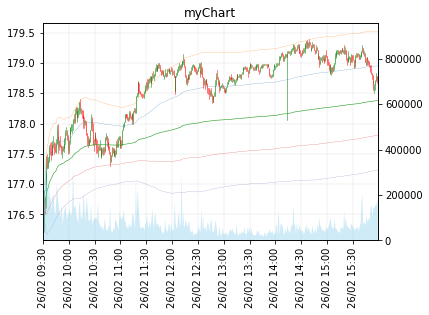

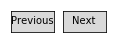

In [15]:

#===========start program ==============
import matplotlib.dates as dt
from calendar import timegm
from datetime import datetime
from pytz import utc

#stockName = 'AAPL.1.29.txt'
stockName = 'AAPL2_26.txt'
# stockName = 'AAPL1day226.txt'
# stockName = 'AMZN.Last227.txt'
len_ma1 = 10
len_ma2 = 20
bb = []
ohlc_data = []

# read data file into a tuple
bb = txt2listMarketHour(fname=stockName)

#process data
for line in bb:
    ohlc_data.append((dates.datestr2num(line[0]),
                      np.float64(line[1]),
                      np.float64(line[2]),
                      np.float64(line[3]),
                      np.float64(line[4]),
                      np.float64(line[5])))
#visioulization

process_data(ohlc_data, stock=stockName)
make_chart(n=4, chart_name="myChart")
class Index(object):
    ind = 0

    def next(self, event):
        self.ind += 1
        noGap_candlestick(ohlc_data, stock=stockName, n=self.ind)

    def prev(self, event):
        self.ind -= 1
        noGap_candlestick(ohlc_data, stock=stockName, n=self.ind)

callback = Index()
axprev = plt.axes([0, 0.9, 0.1, 0.075])
axnext = plt.axes([0.12,0.9, 0.1, 0.075])

bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

plt.show()

#noGap_candlestick(ohlc_data, stock=stockName, n=0)

#===========end of program ==============

len=1950
start, end: 1560--1950
new n = 4
x_min=1560
x_max=1949
 Chart: volume_390[390]; .max()=957400


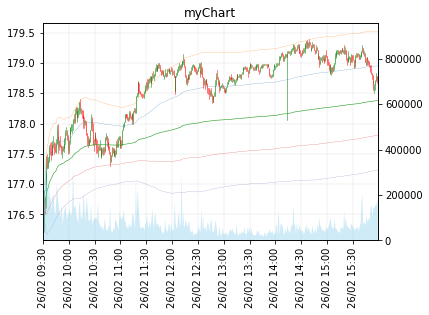

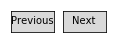

In [19]:
#===========start program ==============
import matplotlib.dates as dt
# from calendar import timegm
# from datetime import datetime
# from pytz import utc

#stockName = 'AAPL.1.29.txt'
stockName = 'AAPL2_26.txt'
# stockName = 'AAPL1day226.txt'
# stockName = 'AMZN.Last227.txt'
len_ma1 = 10
len_ma2 = 20
bb = []
ohlc_data = []

# read data file into a tuple
bb = txt2listMarketHour(fname=stockName)

#process data
for line in bb:
    ohlc_data.append((dates.datestr2num(line[0]),
                      np.float64(line[1]),
                      np.float64(line[2]),
                      np.float64(line[3]),
                      np.float64(line[4]),
                      np.float64(line[5])))
#visioulization

process_data(ohlc_data, stock=stockName)
make_chart(n=4, chart_name="myChart")
class Index(object):
    ind = 0

    def next(self, event):
        self.ind += 1
        noGap_candlestick(ohlc_data, stock=stockName, n=self.ind)

    def prev(self, event):
        self.ind -= 1
        noGap_candlestick(ohlc_data, stock=stockName, n=self.ind)

callback = Index()
axprev = plt.axes([0, 0.9, 0.1, 0.075])
axnext = plt.axes([0.12,0.9, 0.1, 0.075])

bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

plt.show()

#noGap_candlestick(ohlc_data, stock=stockName, n=0)

#===========end of program ==============